# Import

In [300]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy 

In [2]:
#import data and subset meaningful columns
df = pd.read_csv('/Users/zachstone/notebooks/modulargrid/modulargrid_scrape-main/modules.csv')
df = df[['manufacturer_name', 
         'module_name', 
         'module_type',
         'width',
         'depth',
         'current_plus12V','current_minus12V','current_5V',
         'price',
         'num_racks',
         'tags',
         'availability']]

# EDA
modulesdf contains all eurorack modules, even without brand name, with 'accessories' (blank panels, power strips, expanders) dropped. About 20% of all modules are missing price.

brand_df is the subset for modules with brand names listed. About 10% of prices are missing for branded modules.

Some useful but non-obvious business questions: 
1) What functions are optimal for single-use modules? What are their optimal sizes and pricings?
2) What functions are optimal for multi-use modules? What are their optimal sizes and pricings?
3) What are good choices for combinations of functions for multi-use modules? Are certain groupings more popular at certain sizes? What price points are good for that?
4) What 'gaps' might exist for multi-use modules? E.g. popular functions at that size and price point.

These will have to be broken up. We should look at:
-general correlations

a) popularity of different types

b) size distribution of different types

c) price vs popularity

d) for each type, to what extent does price vs size vs brand vs combos predict popularity

Plan:
1. Single variable
- Distribution for price
- Popularity
- Width

2. Categorical variables
- popularity and function

3. Comparison of variables
- correlation between numerical variables
- popularity and price for single vs multifunction
- size against popularity by function and single vs. multifunction

## Prep

In [276]:
#subset eurorack modules
moduledf = df[df.module_type == 'eurorack']
moduledf.drop('module_type', axis =1, inplace=True)
moduledf['tags'] = moduledf['tags'].str.lower()

#Drop accessories
moduledf['accessory_flag'] = moduledf['tags'].str.contains('power|expander|blank panel')
moduledf = moduledf[moduledf.accessory_flag == False].drop('accessory_flag',axis=1)

#Flag unknown brands
moduledf.loc[:,'brand_known'] = moduledf.manufacturer_name.apply(lambda x: x != 'Other/unknown')

#Get branded modules
df_brands = moduledf.loc[(moduledf.brand_known == True) & moduledf.availability.isin(['unknown','avail'])]

#Add log_price and log_racks
df_brands['log_price'] = np.log(df_brands['price'])
df_brands['log_racks'] = np.log(df_brands['num_racks'])


#Make dfs exploded over function
df_brands['functions'] = df_brands.tags.str.split('-')
brands_exploded = df_brands.explode('functions')

#Multi vs. single function flag
df_brands['multifunction'] = df_brands['functions'].apply(lambda x: len(x)>1)


# moduledf['functions'] = moduledf.tags.str.split('-')
# modules_exploded = moduledf.explode('functions')

numeric = ['width', 'price', 'log_price', 'num_racks', 'log_racks']

/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_1826/1597542314.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf.drop('module_type', axis =1, inplace=True)
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_1826/1597542314.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  moduledf['tags'] = moduledf['tags'].str.lower()
/var/folders/g3/v_62hrbj20d1z2xt6c246v780000gn/T/ipykernel_1826/1597542314.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [51]:
df_brands.columns

Index(['manufacturer_name', 'module_name', 'width', 'depth', 'current_plus12V',
       'current_minus12V', 'current_5V', 'price', 'num_racks', 'tags',
       'availability', 'brand_known', 'functions', 'multifunction',
       'log_price'],
      dtype='object')

In [277]:
df_brands[numeric].describe()

,width,price,log_price,num_racks,log_racks
count,7066.000000,6337.000000,6337.000000,7066.000000,7066.000000
mean,11.425984,205.569355,5.009676,750.310784,5.076368
std,10.099868,192.082718,0.821428,2282.390905,1.744566
min,1.000000,4.000000,1.386294,1.000000,0.000000
25%,6.000000,90.000000,4.499810,45.000000,3.806662
50%,8.000000,160.000000,5.075174,142.000000,4.955827
75%,14.000000,259.000000,5.556828,536.750000,6.285532
max,104.000000,3999.000000,8.293800,52604.000000,10.870547


In [28]:
# brand_dummy = pd.get_dummies(df_brands, columns = ['manufacturer_name']).drop(['depth', 'current_plus12V', 'current_minus12V','current_5V'], axis = 1)

# Single variable stats

## Price is nearly log-normal, with long left tail

(array([   6.,   70.,   92.,  254.,  712., 2135., 2631.,  883.,   81.,
          11.]),
 array([0.        , 0.82937996, 1.65875992, 2.48813988, 3.31751984,
        4.1468998 , 4.97627977, 5.80565973, 6.63503969, 7.46441965,
        8.29379961]),
 <BarContainer object of 10 artists>)

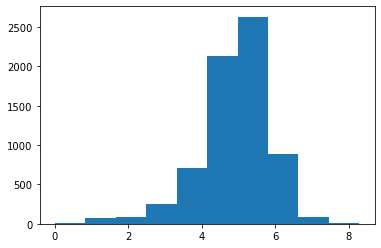

In [42]:
plt.hist(np.log(df_brands.price))

<AxesSubplot:xlabel='price', ylabel='Density'>

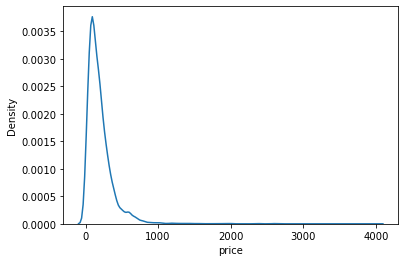

In [45]:
sns.kdeplot(df_brands.price)

<AxesSubplot:xlabel='price', ylabel='Density'>

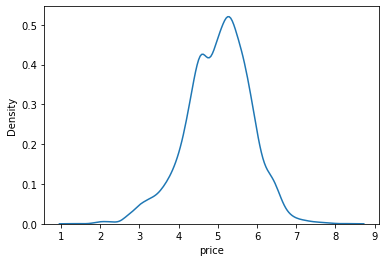

In [297]:
sns.kdeplot(np.log(df_brands.price))

In [298]:
mean_log_price, std_log_price = np.log(df_brands.price).agg([np.mean,np.std]).values

In [322]:
std_log_price * np.random.standard_t(1, size=5000) + mean_log_price

array([ 5.33783525,  5.1682184 , -3.56151628, ...,  4.81307995,
        0.24462628,  5.26529962])

/Users/zachstone/miniforge3/envs/env_tf/lib/python3.9/site-packages/seaborn/distributions.py:2211: UserWarning: `displot` is a figure-level function and does not accept the ax= paramter. You may wish to try histplot.
  warnings.warn(msg, UserWarning)


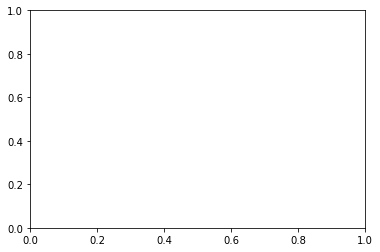

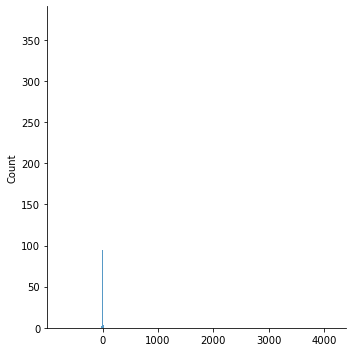

In [333]:
fig, ax = plt.subplots()

# sns.ecdfplot(x='log_racks',data = df_brands, ax =ax);
sns.displot(np.random.standard_t(1, size=5000), ax=ax)

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

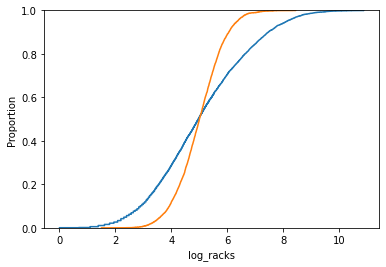

In [299]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_price, scale = std_log_price, size = 5000), ax=ax)

log(price) better behaved, but still not perfectly normal

In [319]:
scipy.stats.describe(df_brands.log_price.dropna().values)

DescribeResult(nobs=6337, minmax=(1.3862943611198906, 8.293799608846818), mean=5.009675841278094, variance=0.6747437410949441, skewness=-0.3363614073023695, kurtosis=0.4946002837322361)

## Popularity is log-normal

<AxesSubplot:ylabel='Frequency'>

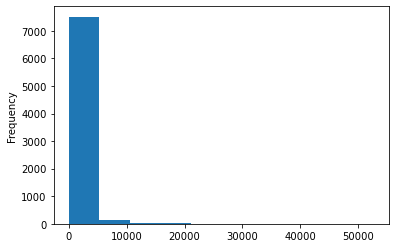

In [53]:
df_brands.num_racks.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

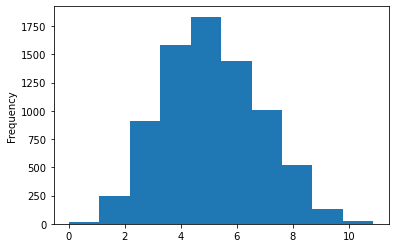

In [54]:
np.log(df_brands.num_racks).plot(kind='hist')

In [269]:
mean_log_pop, std_log_pop = np.log(df_brands.num_racks).agg([np.mean,np.std]).values

<AxesSubplot:xlabel='log_racks', ylabel='Proportion'>

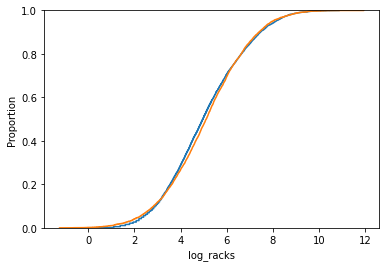

In [287]:
fig, ax = plt.subplots()

sns.ecdfplot(x='log_racks',data = df_brands, ax =ax)
sns.ecdfplot(np.random.normal(loc = mean_log_pop, scale = std_log_pop, size = 5000), ax=ax)

log(num_racks) better behaved

## Size (width in hp)

More idiosyncratic distribution. While there are certain highly frequent sizes, the distribution is not (log-)normal, and the frequent sizes aren't necessarily more popular. A typical distribution and correlation with popularity may only hold within certain subgroups, if at all.

However, the distributions of multi and single function modules do have significantly different means, which should be kept in mind when looking at comparisons against width.

<AxesSubplot:ylabel='Frequency'>

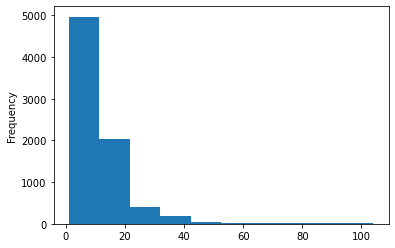

In [56]:
df_brands.width.plot(kind='hist')

<AxesSubplot:ylabel='Frequency'>

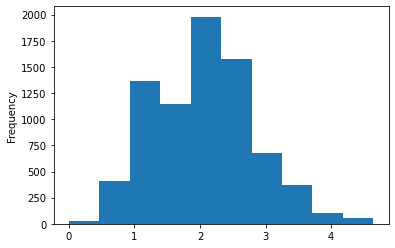

In [63]:
np.log(df_brands.width).plot(kind='hist')

<AxesSubplot:xlabel='width', ylabel='Density'>

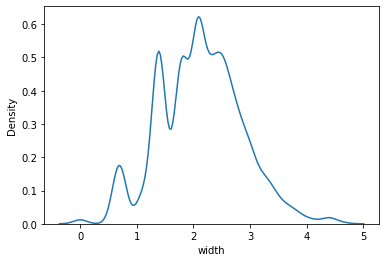

In [216]:
sns.kdeplot(np.log(df_brands.width)) 

Sizes have more unusual distribution. First check against single vs. multifunction.

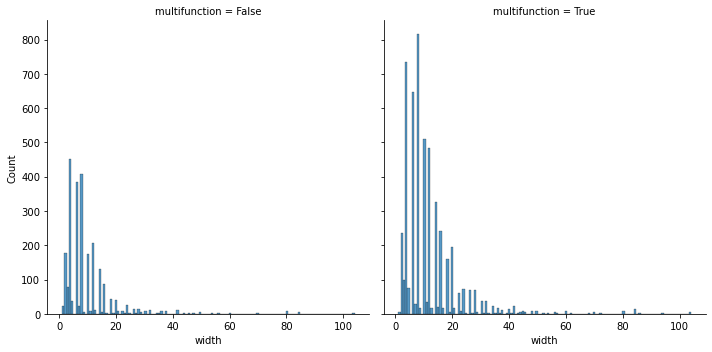

In [76]:
sns.displot(x= 'width', data = df_brands, col = 'multifunction', kind = 'hist', log_scale = False)

Some irregularities are teased apart into the two groups. We look more closely at their distribution, and check that their means are significantly different.

In [78]:
def IQR(dist):
    return np.percentile(dist, 75) - np.percentile(dist, 25)

def cutoff(dist):
    return np.percentile(dist,75) + 1.5 * IQR(dist)

In [79]:
df_brands.groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False           9.684253   9.439345  8.0
True           11.835878  10.570759  8.0

In [17]:
df_brands[df_brands.price.notnull()].groupby('multifunction')[['width']].agg([np.mean,np.std,IQR])

width                
                    mean        std  IQR
multifunction                           
False           9.631026   9.214824  8.0
True           11.684519  10.362061  8.0

Single and multi-use modules have similar width distributions, with multifunction being larger by about 2hp.

We can check if the difference is signficant with a 2-sample ttest with p=0.05.

In [80]:
from scipy.stats import ttest_ind

In [81]:
multifunction_w = df_brands[df_brands.multifunction].loc[:,'width'].values
singlefunction_w = df_brands[~df_brands.multifunction].loc[:,'width'].values

In [82]:
ttest_ind(multifunction_w, singlefunction_w, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=8.97400104447829, pvalue=1.9443724343736323e-19)

The result is significant, so we can assume they come from different distributions.

We also note that visual inspection shows some very frequent sizes. It may be that these sizes are 'standards' which skew the distribution. In this way, the frequent sizes may be more like ordered categoricals/classes.

In [219]:
# df_brands.width.value_counts(sort=True, normalize=True).iloc[::-1].plot(kind='barh', figsize = (5,12))

In [90]:
df_brands.width.value_counts(sort=True, normalize=True).head(20)

8.0     0.158619
4.0     0.153816
6.0     0.133697
12.0    0.089694
10.0    0.089045
14.0    0.059190
2.0     0.053609
16.0    0.042835
20.0    0.030763
18.0    0.026480
3.0     0.022845
5.0     0.014538
24.0    0.012721
28.0    0.010903
26.0    0.010774
22.0    0.009216
7.0     0.006490
32.0    0.006231
30.0    0.005582
11.0    0.005452
Name: width, dtype: float64

We can see that after 2hp, the proportion of modules of each size quickly drops below 5% of all modules. Let's check if there are any popularity standouts by width.

In [92]:
df_brands.width.unique().size

63

We look at the popularity of each width for single and multifunction modules

<AxesSubplot:ylabel='width'>

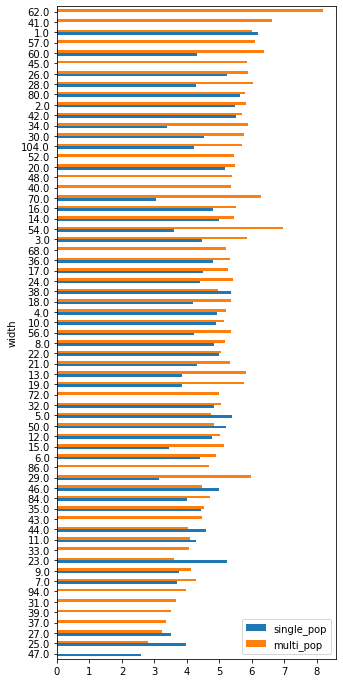

In [243]:
width_pop = df_brands.groupby(['multifunction', 'width'])[['log_racks']]\
                .mean().unstack().T.reset_index('width').reset_index(drop=True)
width_pop.columns = ['width', 'single_pop', 'multi_pop']
width_pop = width_pop.merge(df_brands.groupby('width')[['log_racks']].mean().reset_index(), on = 'width', how='outer')
width_pop.sort_values(by='log_racks').drop('log_racks', axis=1).plot(x = 'width', kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='width'>

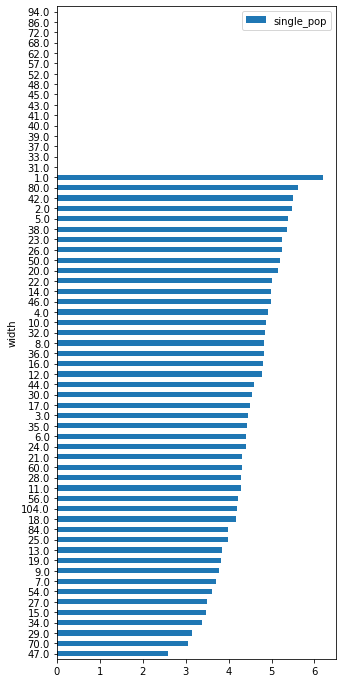

In [248]:
width_pop[['width','single_pop']].sort_values('single_pop').plot(x='width', kind = 'barh', figsize = (5,12))

In [250]:
width_pop[['width','multi_pop']].sort_values('multi_pop').plot(x='width', kind = 'barh', figsize = (5,12))

Neither group particularly had the most frequent sizes among the most popular. It is likely popularity vs size only shows up within certain subgroups, if it is a predictor at all.

# Comparison of variables

## Popularity vs. function/type
Multifunction modules will be counted in every category they are contained in when looking at stats by function. 

We will also look at multi v. single function and popularity

Text(0.5, 1.0, 'Multifunction vs. Popularity')

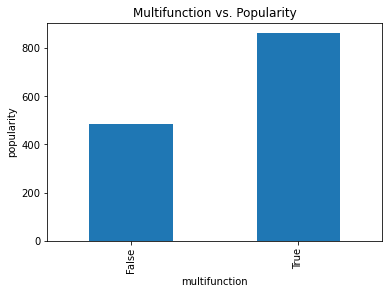

In [260]:
ax = df_brands.groupby('multifunction')['num_racks'].mean().plot(kind = 'bar') #multifunction modules are significantly more popular
ax.set_ylabel('popularity')
ax.set_title('Multifunction vs. Popularity')

We can clearly see that multifunction modules are more popular than single function. To verify:

In [278]:
multifunction_p = df_brands[df_brands.multifunction].loc[:,'num_racks'].values
singlefunction_p = df_brands[~df_brands.multifunction].loc[:,'num_racks'].values

In [279]:
ttest_ind(multifunction_p, singlefunction_p, equal_var = False, random_state = 53, alternative = 'greater')

Ttest_indResult(statistic=8.063546919636027, pvalue=4.3445084120283227e-16)

In [251]:
# brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

<AxesSubplot:ylabel='functions'>

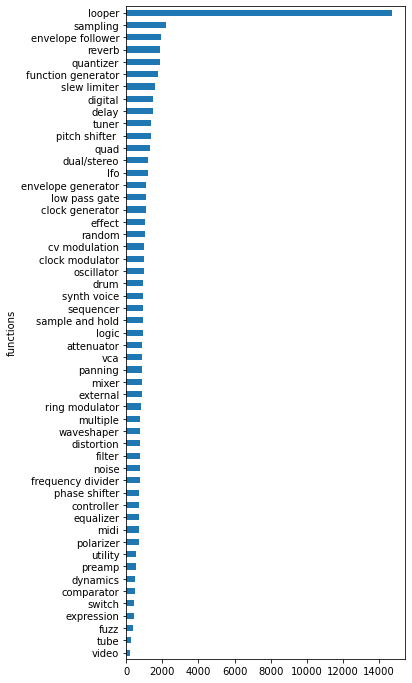

In [262]:
#All functions by popularity
brands_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [5]:
# modules_exploded.groupby('functions')['num_racks'].mean().sort_values().plot(kind='barh', figsize = (5,12))

In [258]:
brands_exploded.groupby('functions')['num_racks'].mean().sort_values(ascending=False).index

Index(['looper', 'sampling', 'envelope follower', 'reverb', 'quantizer',
       'function generator', 'slew limiter', 'digital', 'delay', 'tuner',
       'pitch shifter ', 'quad', 'dual/stereo', 'lfo', 'envelope generator',
       'low pass gate', 'clock generator', 'effect', 'random', 'cv modulation',
       'clock modulator', 'oscillator', 'drum', 'synth voice', 'sequencer',
       'sample and hold', 'logic', 'attenuator', 'vca', 'panning', 'mixer',
       'external', 'ring modulator', 'multiple', 'waveshaper', 'distortion',
       'filter', 'noise', 'frequency divider', 'phase shifter', 'controller',
       'equalizer', 'midi', 'polarizer', 'utility', 'preamp', 'dynamics',
       'comparator', 'switch', 'expression', 'fuzz', 'tube', 'video'],
      dtype='object', name='functions')

In [259]:
brands_exploded.functions.unique().size

53

## Function vs. price

Text(0.5, 1.0, 'Multifunction vs. Price')

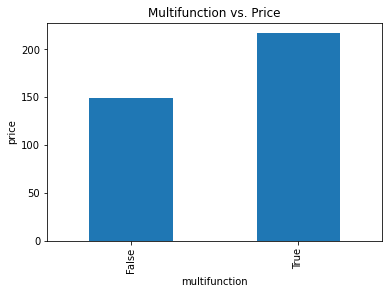

In [9]:
ax = df_brands.groupby('multifunction')['price'].mean().plot(kind='bar') #however, they are not significantly more expensive
ax.set_ylabel('price')
ax.set_title('Multifunction vs. Price')

## EDA Q3: What is the optimal size for each type of module to enhance popularity?

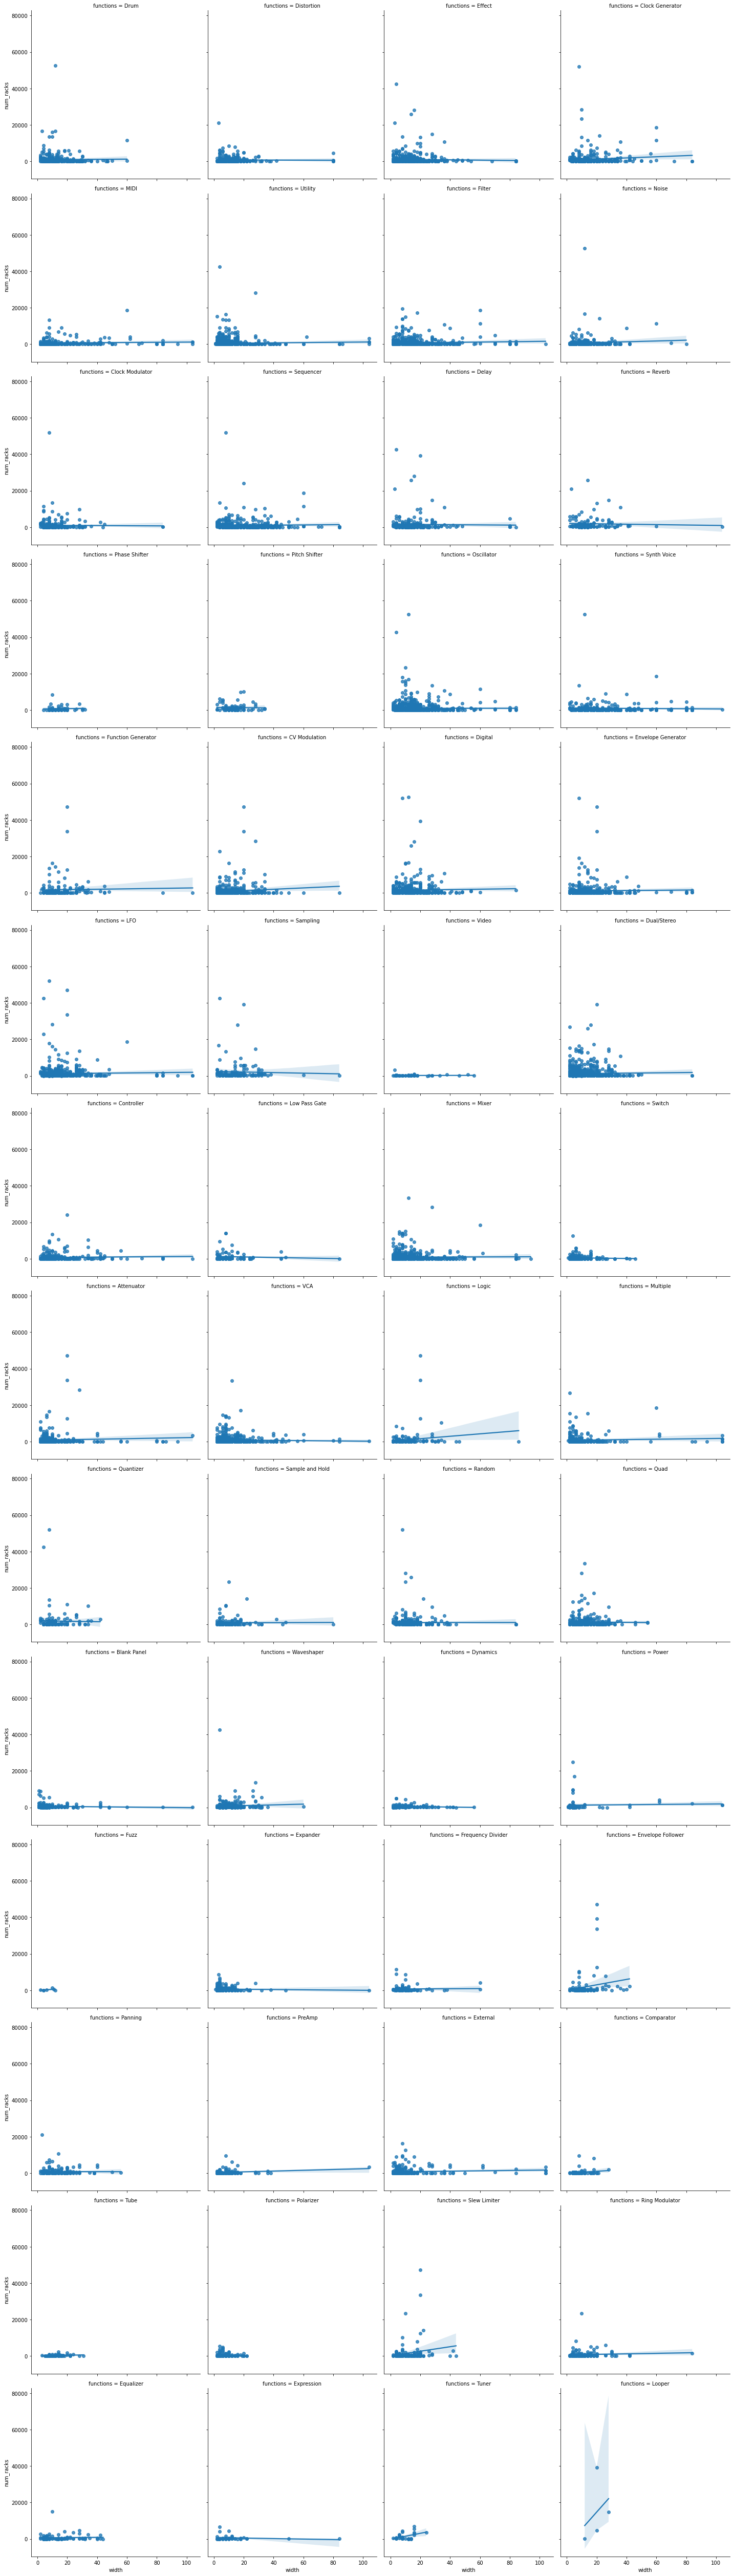

In [11]:
sns.lmplot(x = 'width', y = 'num_racks', data = brands_exploded, col = 'functions', col_wrap = 4)

As expected, the relationship between size and popularity is nonlinear, with popularity leaning towards mid-small sized modules.
To begin analysis of size, we look for size outliers in each category.

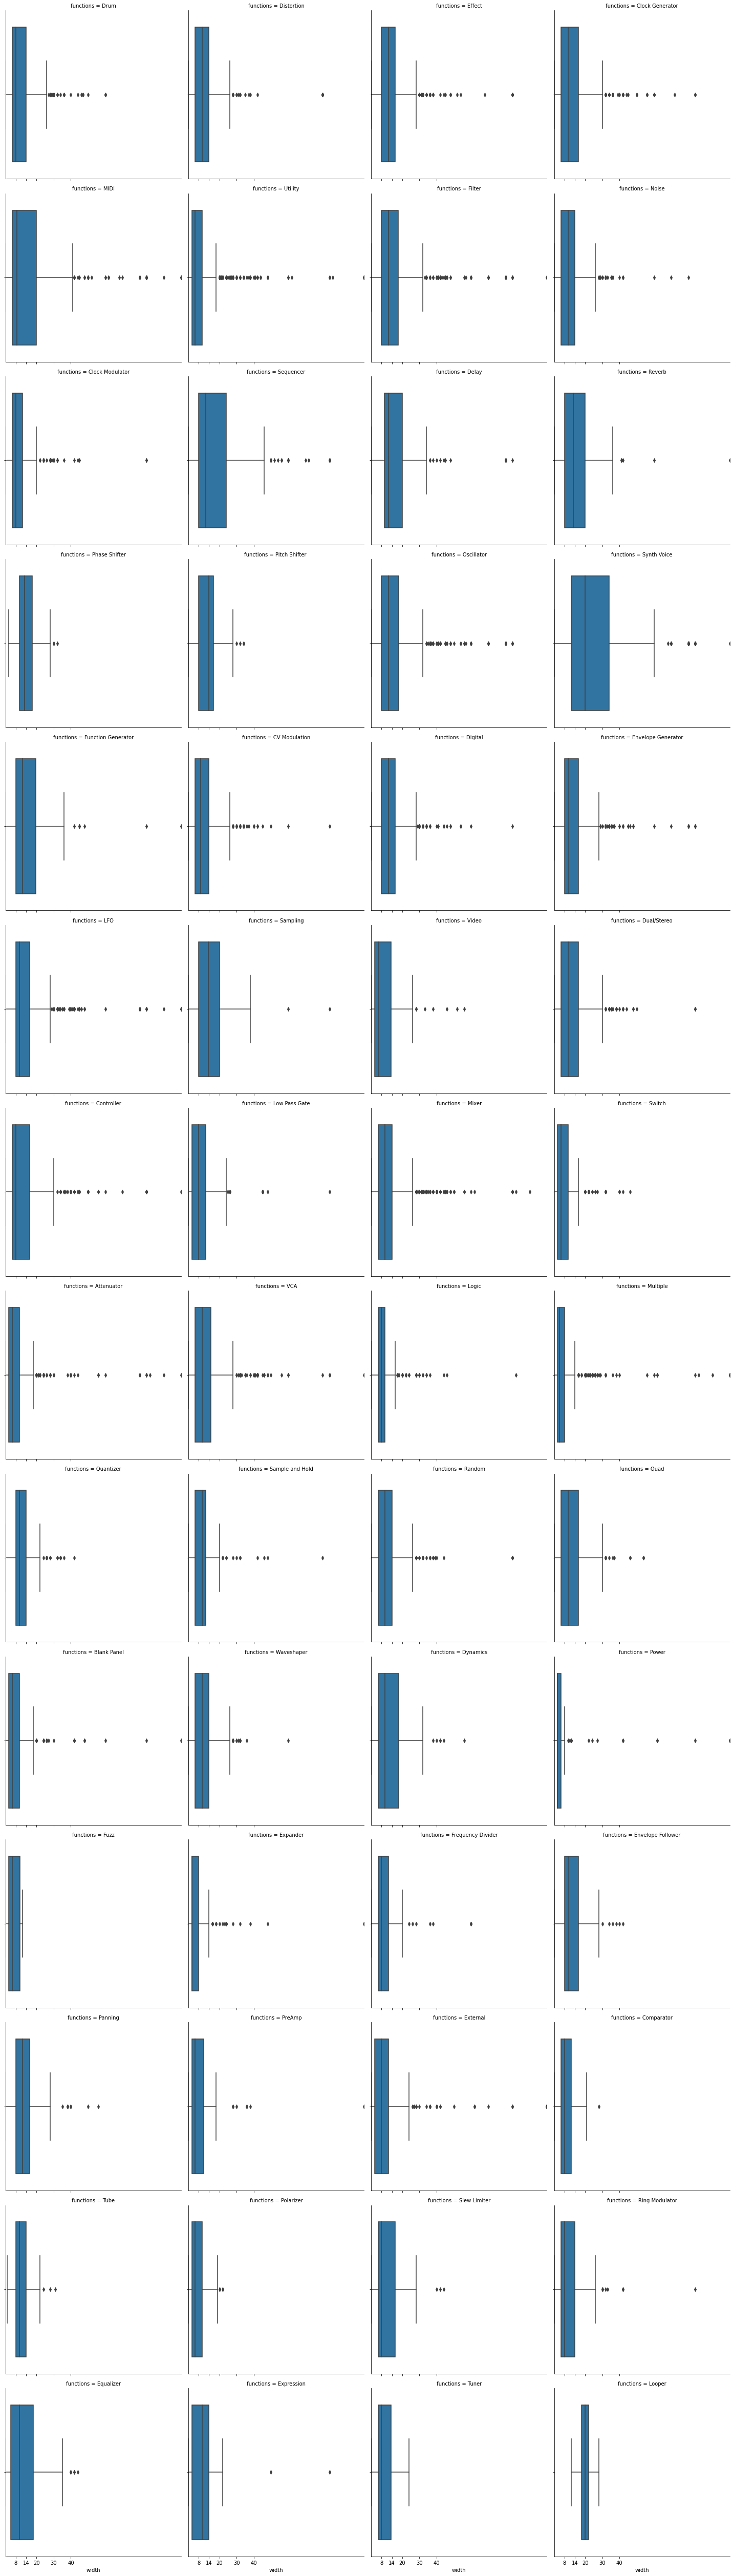

In [12]:
g = sns.catplot(x = 'width', col = 'functions', col_wrap = 4, data = brands_exploded, kind = 'box')
g.set(xlim = (2,np.max(brands_exploded.width)), xticks = [8, 14, 20, 30, 40])

The distribution of outliers over 1.5IQR above Q3 varies greatly between functions, suggesting that they may be different in each group. We should examine the outlier for each kind. This may be due to many factors, such as the outliers for certain functions being due to commonly being on multifunction modules, which may be larger.

In [14]:
function_widths = [*brands_exploded.groupby('functions')['width']]

In [15]:
#Inspecting outliers for each group may be too complicated
# print(function_widths[0][0])
# print(cutoff(function_widths[0][1]))
# np.array(function_widths[0][1:]).reshape(-1,)[(function_widths[0][1] > cutoff(function_widths[0][1:])).values]

## Price and popularity